In [1]:
# This is a cleaned up solution to the Titanic problem. 
# Some of the strategies used come from the following ressources : 
# - https://www.youtube.com/watch?v=Ea_KAcdv1vs&t=142s
# - https://www.kaggle.com/code/gusthema/titanic-competition-w-tensorflow-decision-forests
# - https://www.youtube.com/watch?v=I3FBJdiExcg
# - https://www.kaggle.com/code/alifioditya/titanic-classification-basic-pipeline
# - https://towardsdatascience.com/class-imbalance-strategies-a-visual-guide-with-code-8bc8fae71e1a

# Loading the packages used

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt

## Importing the data

In [2]:
train_df = pd.read_csv('dataset/train.csv')
serving_df = pd.read_csv('dataset/test.csv')

## 1. Data Exploration

We will start by understanding the structure of our data.

In [3]:
train_df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
serving_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [6]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


We visualize the missing data. However, we must be careful when using this method, because not all data will necessarily be visible. For instance, the 'Embarked' column has two absent entries which are not necessarily visible in a heatmap. It is better to rely on the info() method of the dataframe.

<AxesSubplot:>

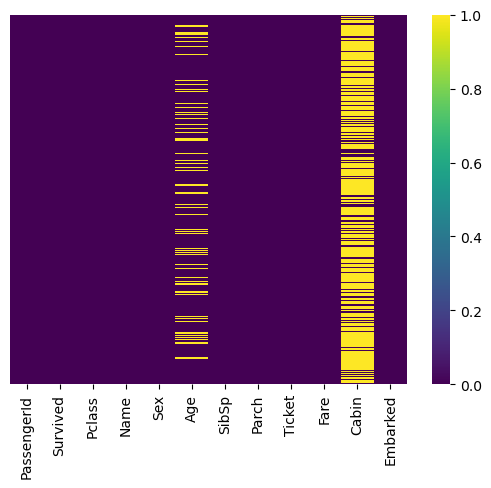

In [7]:
# We can use seaborn to create a simple heatmap to see where the missing data are.
sns.heatmap(train_df.isnull(), yticklabels=False, cmap='viridis')

In [8]:
unique_cabin_count = len(train_df['Cabin'].unique())
non_null_cabin_count = len(train_df[train_df['Cabin'].notnull()]) 

print('There are {} unique cabin values out of the {} values that are not null'.format(unique_cabin_count, non_null_cabin_count))

There are 148 unique cabin values out of the 204 values that are not null


We observe that only the columns 'Age' and 'Cabin' contain missing data.
When it comes to the age, it appears that there are reasonable few ages missing. We should be able to come up with a form of data imputation.
When it comes to the cabin, there are only 204 values that are not null (and out of them, almot 75% are unique values). We will transform this feature into a binary feature indicating whether or not they had an assigned cabin. 

Moreover, in the serving data, there is also a missing fare that should be imputed.

<AxesSubplot:xlabel='Survived', ylabel='count'>

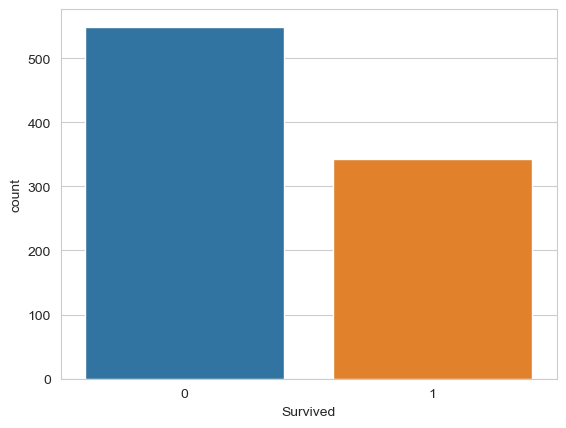

In [9]:
sns.set_style('whitegrid')
sns.countplot(x='Survived', data=train_df)

<AxesSubplot:xlabel='Survived', ylabel='count'>

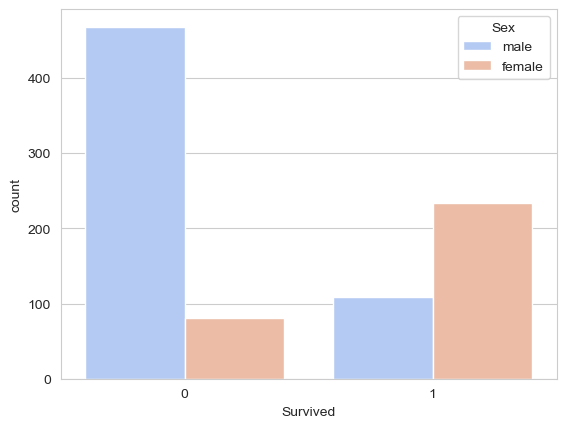

In [10]:
sns.set_style('whitegrid')
sns.countplot(x='Survived', data=train_df, hue='Sex', palette='coolwarm')

We notice that men were much more likely to not have survived.

<AxesSubplot:xlabel='Survived', ylabel='count'>

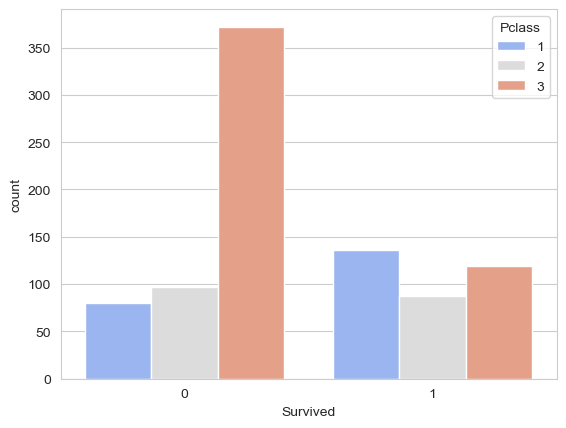

In [11]:
sns.set_style('whitegrid')
sns.countplot(x='Survived', data=train_df, hue='Pclass', palette='coolwarm')

We observe that the passager of class 1 were much more likely to not have survived.

<AxesSubplot:xlabel='Age', ylabel='Count'>

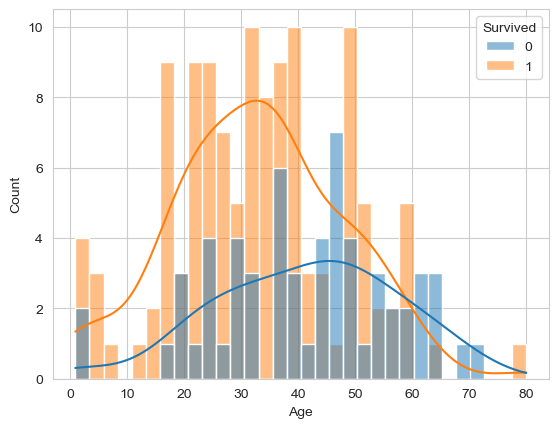

In [12]:
sns.histplot(x='Age', data=train_df.dropna(), hue='Survived', kde=True, color='darkred', bins=32)

We observe that the averge age is somewhere between 20 and 30 years old. Based on this distribution, it would not be unreasonable to use this average age to inpute an age where the ages are missing.

<AxesSubplot:xlabel='Survived', ylabel='count'>

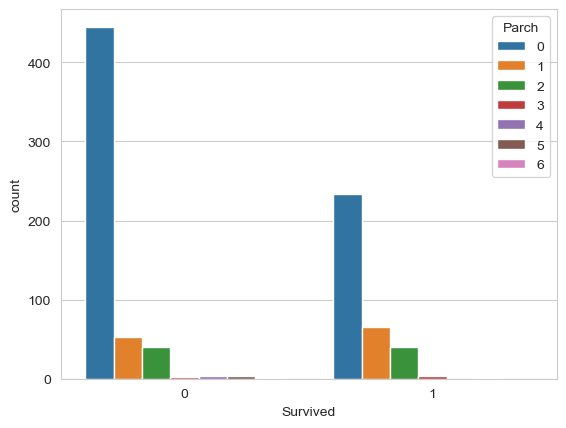

In [13]:
sns.countplot(x='Survived', data=train_df, hue='Parch')

<AxesSubplot:xlabel='Survived', ylabel='count'>

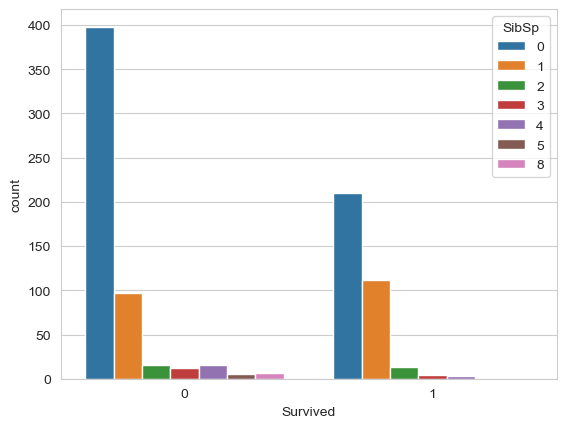

In [14]:
sns.countplot(x='Survived', data=train_df, hue='SibSp')

We do not really get a lot of information from the 'Parch' features and the 'SibSp' feature, aside from observing that the values are generally low (around 0, 1 or 2). Otherwise, the distribution of survival vs death is quite visibly similiar for all the values of these features. That being said, we do see that when people had 3 or more SibSp or Parch, they were more likely to not have survived.

<AxesSubplot:xlabel='Fare', ylabel='Count'>

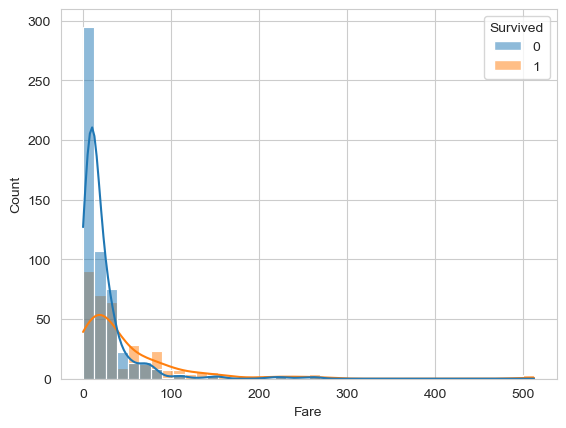

In [15]:
sns.histplot(x='Fare', data=train_df, kde=True, hue='Survived', bins=40)

We observe that the fare are generally low (somwhat remanescent of a poisson distribution).

<AxesSubplot:xlabel='Survived', ylabel='count'>

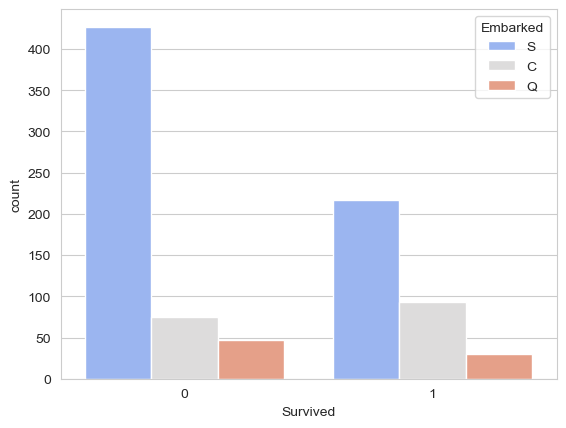

In [16]:
sns.countplot(x='Survived', data=train_df, hue='Embarked', palette='coolwarm')

We do not observe a particular trend based on the 'Embarked' feature.

In [17]:
train_df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

## 2. Data cleaning and preprocessing

### Fare

For the one missing fare in the serving data, se simply impute the mean value of the serving data

In [18]:
serving_df.loc[serving_df['Fare'].isnull(), 'Fare'] = round(serving_df['Fare'].mean())

### Cabin

We will want to remove the cabin column and replace it by a column that indicates whether or not there a cabin indicated.

In [19]:
train_df['Has_Cabin'] = train_df['Cabin'].notnull()
serving_df['Has_Cabin'] = serving_df['Cabin'].notnull()

### Age

We want to impute an age to the user that do not have mone assigned. We try to assign an age to the users based on a criterea (instead of assigning the average age to everyone).

PassengerId    0.036847
Survived      -0.077221
Pclass        -0.369226
Age            1.000000
SibSp         -0.308247
Parch         -0.189119
Fare           0.096067
Has_Cabin      0.249732
Name: Age, dtype: float64


<AxesSubplot:xlabel='Pclass', ylabel='Age'>

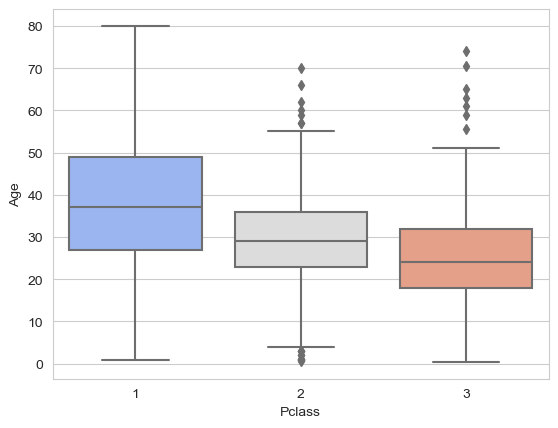

In [20]:
print(train_df.corr()['Age'])
sns.boxplot(x='Pclass', y='Age', data=train_df, palette='coolwarm')

We obser that there is a relatively good corelation between the average age and the class of the passanger. The passenger in better classes tend to be older. Thus, we will use the average per class in order to assign the missing values of the ages of the passangers.

In [21]:
print('Average age for calss 1:', round(train_df.loc[train_df['Pclass'] == 1, 'Age'].dropna().mean()))
print('Average age for calss 2:', round(train_df.loc[train_df['Pclass'] == 2, 'Age'].dropna().mean()))
print('Average age for calss 3:', round(train_df.loc[train_df['Pclass'] == 3, 'Age'].dropna().mean()))

Average age for calss 1: 38
Average age for calss 2: 30
Average age for calss 3: 25


In [22]:
def impute_age(df):
    Age = df['Age']
    Pclass = df['Pclass']
    
    if pd.isnull(Age):
        if Pclass == 1:
            return 38
        
        elif Pclass == 2:
            return 30
        
        else:
            return 25
        
    else:
        return Age
    
train_df['Age'] = train_df[['Age', 'Pclass']].apply(impute_age, axis=1)
serving_df['Age'] = serving_df[['Age', 'Pclass']].apply(impute_age, axis=1)

### Embarked

Finally, we must also fill the missing values of the 'Embarked' column

In [23]:
train_df.loc[train_df['Embarked'].isnull(), 'Embarked'] = 'NA'
serving_df.loc[serving_df['Embarked'].isnull(), 'Embarked'] = 'NA'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     891 non-null    object 
 12  Has_Cabin    891 non-null    bool   
dtypes: bool(1), float64(2), int64(5), object(5)
memory usage: 84.5+ KB


<AxesSubplot:>

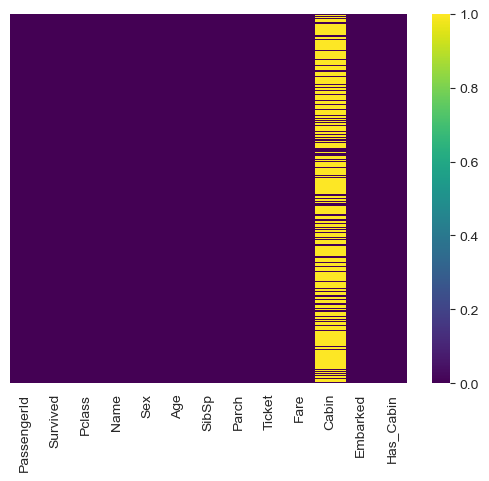

In [24]:
train_df.info()
sns.heatmap(train_df.isnull(), yticklabels=False, cmap='viridis')

## 4. Feature engineering

### Title

We will retreive the title of each passenger as displayed in their name.

In [25]:
train_df['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [26]:
def extract_title(name):
    title = name.split(', ')
    title = title[-1]
    title = title.split(' ')
    title = title[0]
    return title

train_df['Title'] = train_df['Name'].apply(extract_title)
serving_df['Title'] = serving_df['Name'].apply(extract_title)
train_df['Title'].head()

0      Mr.
1     Mrs.
2    Miss.
3     Mrs.
4      Mr.
Name: Title, dtype: object

<AxesSubplot:xlabel='Title', ylabel='count'>

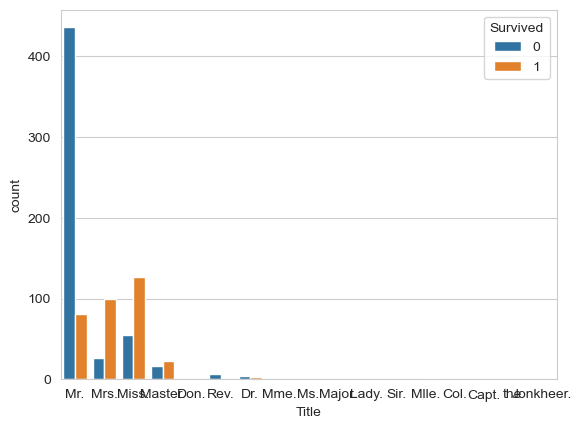

In [27]:
sns.countplot(x='Title', data=train_df, hue='Survived')

The 6 classes with the most element could be kep as features, but the other values have too few element to provide any meaningful insight.

In [28]:
titles_to_keep = ['Mr.', 'Mrs.', 'Miss.', 'Master', 'Rev.', 'Dr.']

train_df.loc[~train_df['Title'].isin(titles_to_keep), 'Title'] = 'NA'
serving_df.loc[~serving_df['Title'].isin(titles_to_keep), 'Title'] = 'NA'

train_df['Title'].unique()

array(['Mr.', 'Mrs.', 'Miss.', 'NA', 'Rev.', 'Dr.'], dtype=object)

<AxesSubplot:xlabel='Title', ylabel='count'>

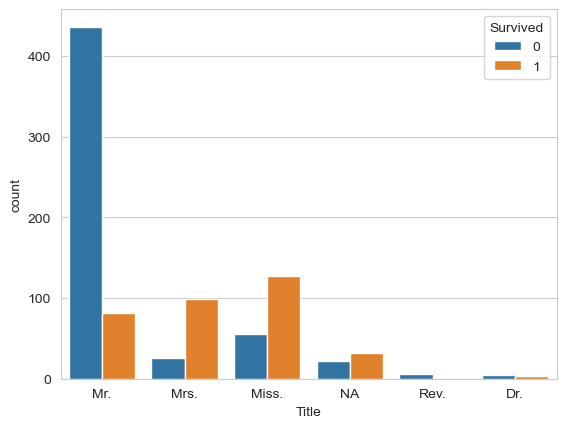

In [29]:
sns.countplot(x='Title', data=train_df, hue='Survived')

### Ticket Number

We could also try to see if there is a correlation between the ticket number and the survival rate.

In [30]:
train_df['Ticket'].head(n=10)

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
5              330877
6               17463
7              349909
8              347742
9              237736
Name: Ticket, dtype: object

In [31]:
def extract_ticket_number(ticket):
    number = ticket.split(' ')
    number = number[-1]
    if number.isdigit():
        return int(number)
    else:
        return 0

train_df['Ticket_Number'] = train_df['Ticket'].apply(extract_ticket_number)
serving_df['Ticket_Number'] = serving_df['Ticket'].apply(extract_ticket_number)

<AxesSubplot:xlabel='Ticket_Number', ylabel='Count'>

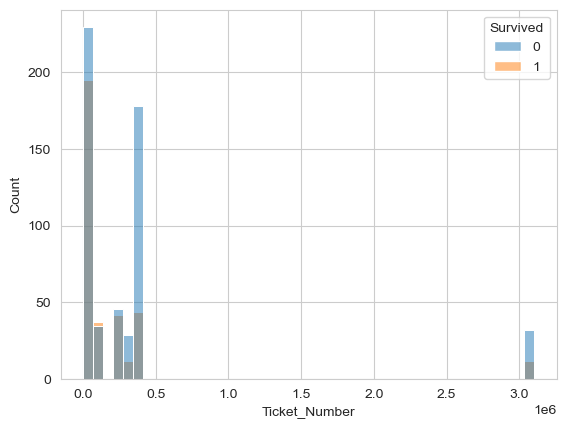

In [32]:
sns.histplot(data=train_df, x='Ticket_Number', hue='Survived')

There seems to be some interesting trends that can be detected from the ticket number. We will keep this feature, but we will normalize it. 

### Ticket Text

We might as well try to see if there is an interesting property that can be detected from the text parts of the ticket information.

In [33]:
def extract_ticket_text(ticket):
    text = ticket.split(' ')
    text = text[:-1]
    text.append('NA')
    text = ' '.join(text)
    text = text.split('/')
    text = text[0]
    text = text.split(' ')
    text = text[0]
    text = text.split('.')
    text = text[0]
    if text.isdigit():
        return 'NA'
    else:
        return text
    
train_df['Ticket_Text'] = train_df['Ticket'].apply(extract_ticket_text)
serving_df['Ticket_Text'] = serving_df['Ticket'].apply(extract_ticket_text)
train_df['Ticket_Text'].unique()

array(['A', 'PC', 'STON', 'NA', 'PP', 'C', 'SC', 'S', 'CA', 'SO', 'W',
       'SOTON', 'A4', 'Fa', 'F', 'SW', 'SCO', 'P', 'WE'], dtype=object)

<AxesSubplot:xlabel='Ticket_Text', ylabel='Count'>

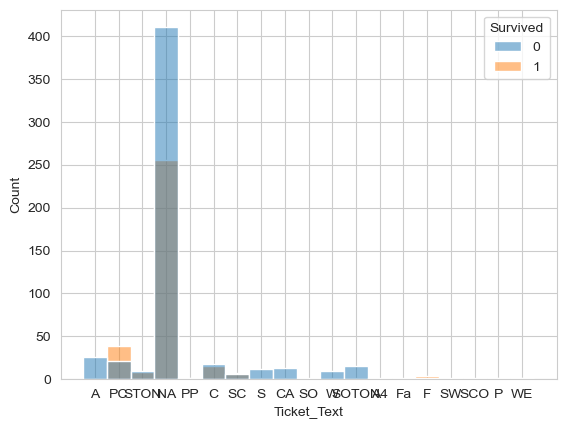

In [34]:
sns.histplot(x='Ticket_Text', data=train_df, hue='Survived')

We will keep the 10 most common values and group all the other ones in a 'OHTER' category.

In [35]:
ticket_text_to_keep =  train_df['Ticket_Text'].value_counts()[:10].index.tolist()

<AxesSubplot:xlabel='Ticket_Text', ylabel='Count'>

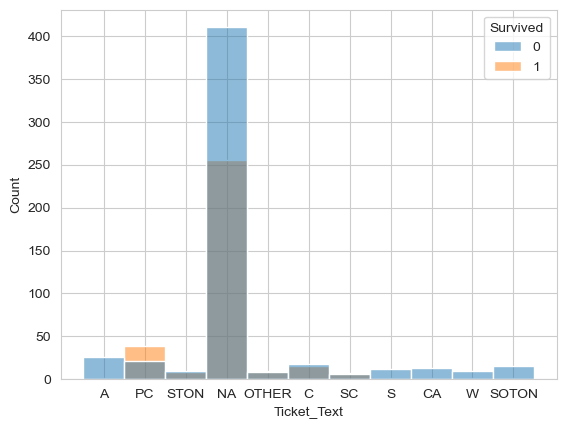

In [36]:
train_df.loc[~train_df['Ticket_Text'].isin(ticket_text_to_keep), 'Ticket_Text'] = 'OTHER'
serving_df.loc[~serving_df['Ticket_Text'].isin(ticket_text_to_keep), 'Ticket_Text'] = 'OTHER'

train_df['Ticket_Text'].unique()
sns.histplot(x='Ticket_Text', data=train_df, hue='Survived')

In [37]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    891 non-null    int64  
 1   Survived       891 non-null    int64  
 2   Pclass         891 non-null    int64  
 3   Name           891 non-null    object 
 4   Sex            891 non-null    object 
 5   Age            891 non-null    float64
 6   SibSp          891 non-null    int64  
 7   Parch          891 non-null    int64  
 8   Ticket         891 non-null    object 
 9   Fare           891 non-null    float64
 10  Cabin          204 non-null    object 
 11  Embarked       891 non-null    object 
 12  Has_Cabin      891 non-null    bool   
 13  Title          891 non-null    object 
 14  Ticket_Number  891 non-null    int64  
 15  Ticket_Text    891 non-null    object 
dtypes: bool(1), float64(2), int64(6), object(7)
memory usage: 105.4+ KB


## 5. Data processing for model

Tranforming the data into numerical values and retreiving only the columns needed the training and for preditions.

### Rescaling and one hot encoding

In [38]:
# Categorical features
categorical_features = ['Sex', 'Has_Cabin', 'Pclass', 'Embarked', 'Title', 'Ticket_Text']

# Numerical features
numerical_features = ['Age', 'SibSp', 'Parch', 'Fare', 'Ticket_Number']

In [39]:
# Encoding the categorical features
one_hot_encoder = OneHotEncoder(drop='if_binary')
one_hot_encoder.fit(train_df[categorical_features])

categorical_train_df = pd.DataFrame(columns=one_hot_encoder.get_feature_names_out(), 
                                    data=one_hot_encoder.transform(train_df[categorical_features]).toarray())
categorical_serving_df = pd.DataFrame(columns=one_hot_encoder.get_feature_names_out(), 
                                      data=one_hot_encoder.transform(serving_df[categorical_features]).toarray())

In [40]:
# Rescaling the numerical features
minmax_scaler = MinMaxScaler()
minmax_scaler.fit(train_df[numerical_features])

numerical_train_df = pd.DataFrame(columns=minmax_scaler.get_feature_names_out(), 
                                  data=minmax_scaler.transform(train_df[numerical_features]))
numerical_serving_df = pd.DataFrame(columns=minmax_scaler.get_feature_names_out(), 
                                    data=minmax_scaler.transform(serving_df[numerical_features]))

In [41]:
input_features = list(one_hot_encoder.get_feature_names_out()) + numerical_features

# We do not need this feature as there were only two data points for the training
input_features.remove('Embarked_NA')

print(f'Input features: {input_features},\n That is a total of {len(input_features)} features.')

Input features: ['Sex_male', 'Has_Cabin_True', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Dr.', 'Title_Miss.', 'Title_Mr.', 'Title_Mrs.', 'Title_NA', 'Title_Rev.', 'Ticket_Text_A', 'Ticket_Text_C', 'Ticket_Text_CA', 'Ticket_Text_NA', 'Ticket_Text_OTHER', 'Ticket_Text_PC', 'Ticket_Text_S', 'Ticket_Text_SC', 'Ticket_Text_SOTON', 'Ticket_Text_STON', 'Ticket_Text_W', 'Age', 'SibSp', 'Parch', 'Fare', 'Ticket_Number'],
 That is a total of 30 features.


In [42]:
input_train_df = pd.concat([categorical_train_df, numerical_train_df], axis=1)[input_features]
input_serving_df = pd.concat([categorical_serving_df, numerical_serving_df], axis=1)[input_features]

input_train_df = input_train_df.astype(float)
input_serving_df = input_serving_df.astype(float)

input_train_df.head()

,Sex_male,Has_Cabin_True,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Title_Dr.,Title_Miss.,...,Ticket_Text_S,Ticket_Text_SC,Ticket_Text_SOTON,Ticket_Text_STON,Ticket_Text_W,Age,SibSp,Parch,Fare,Ticket_Number
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.271174,0.125,0.0,0.014151,0.006826
1,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.472229,0.125,0.0,0.139136,0.005675
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.321438,0.000,0.0,0.015469,0.999989
3,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.434531,0.125,0.0,0.103644,0.036695
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.434531,0.000,0.0,0.015713,0.120417


In [43]:
output_train = train_df['Survived']

It should be noted that there was also the option to use 'from sklearn.preprocessing import StandardScaler' to scale the features.

### Splitting the data for training and validation

In [44]:
X = input_train_df
y = train_df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### Balancing the dataset through Oversampling

Different strategies to balance the samples include : 
- Oversampling
- Undersampling
- Class weight
- Decision threshold
https://towardsdatascience.com/how-to-balance-a-dataset-in-python-36dff9d12704

In this solution, we will use oversampling.

In [45]:
def plot_classes(y):
    plt.title('Class distribution')
    plt.pie(x=y.value_counts(), autopct='%.2f', labels=['Dead', 'Survived'])
    
    print(y.value_counts())

0    443
1    269
Name: Survived, dtype: int64


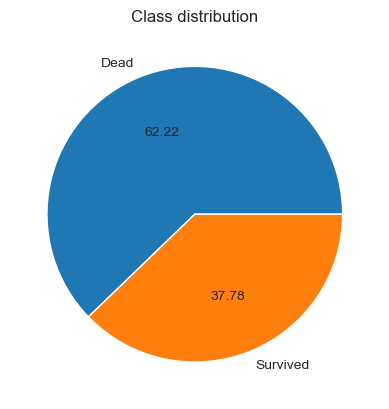

In [46]:
plot_classes(y_train)

1    443
0    443
Name: Survived, dtype: int64


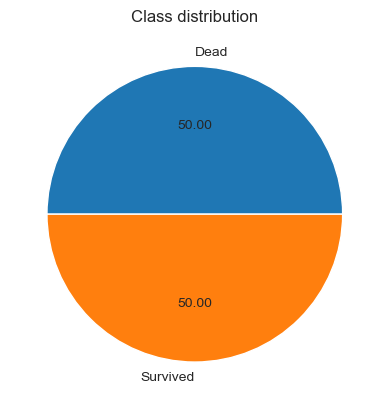

In [47]:
smote_oversampler = SMOTE(random_state=1)
X_train_res, y_train_res = smote_oversampler.fit_resample(X_train, y_train)
plot_classes(y_train_res)

## 6. Model building

In [48]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

### Random Forest Classifier

Tuning

In [49]:
rf_clf_param_grid = {
    'max_features': ['sqrt', None],
    'max_depth': [2, 4, 6, 8, 10, None],
    'n_estimators': [100,200,300,400,500],
    'max_depth': [3, 6, 9, 12]
}

In [50]:
rf_clf_grid_searcher = GridSearchCV(estimator=RandomForestClassifier(), 
                                    param_grid=rf_clf_param_grid, 
                                    n_jobs=-1,
                                    scoring='accuracy',
                                    verbose=3)
rf_clf_grid_searcher.fit(X_train_res, y_train_res)
print(f'The best parameters are : {rf_clf_grid_searcher.best_params_}')

Fitting 5 folds for each of 40 candidates, totalling 200 fits
The best parameters are : {'max_depth': 12, 'max_features': 'sqrt', 'n_estimators': 200}


In [51]:
rf_clf_grid_searcher.score(X_test, y_test)

0.7821229050279329

In [52]:
rf_clf = RandomForestClassifier()
rf_clf.set_params(**rf_clf_grid_searcher.best_params_)

RandomForestClassifier(max_depth=12, n_estimators=200)

### Adaboost

Tunning

In [53]:
adaboost_clf_param_grid = {
    'n_estimators': [50, 100, 250, 500, 1000, 1500],
    'learning_rate': [0.25, 0.5, 1, 5]
}

In [54]:
adaboost_clf_grid_searcher = GridSearchCV(estimator=AdaBoostClassifier(), 
                                          param_grid=adaboost_clf_param_grid, 
                                          n_jobs=-1,
                                          scoring='accuracy',
                                          verbose=3)
adaboost_clf_grid_searcher.fit(X_train_res, y_train_res)
print(f'The best parameters are : {adaboost_clf_grid_searcher.best_params_}')

Fitting 5 folds for each of 24 candidates, totalling 120 fits
The best parameters are : {'learning_rate': 0.5, 'n_estimators': 250}


In [55]:
adaboost_clf_grid_searcher.score(X_test, y_test)

0.770949720670391

In [56]:
adaboost_clf = AdaBoostClassifier()
adaboost_clf.set_params(**adaboost_clf_grid_searcher.best_params_)

AdaBoostClassifier(learning_rate=0.5, n_estimators=250)

### XBoost

In [57]:
xgboost_clf_param_grid = {
    'n_estimators': [50, 100, 250, 500],
    'max_depth': [5, 10, 15, 20],
    'learning_rate': [0.25, 0.5, 1, 5],
    'gamma': [0.01, 0.05, 0.1],
    'reg_lambda': [0.1, 0.5, 1], 
    'reg_alpha': [0.1, 0.5, 1], 
}

In [58]:
xgboost_clf_grid_searcher = GridSearchCV(estimator=XGBClassifier(), 
                                         param_grid=xgboost_clf_param_grid, 
                                         n_jobs=-1,
                                         scoring='accuracy',
                                         verbose=3)
xgboost_clf_grid_searcher.fit(X_train_res, y_train_res)
print(f'The best parameters are : {xgboost_clf_grid_searcher.best_params_}')

Fitting 5 folds for each of 1728 candidates, totalling 8640 fits
The best parameters are : {'gamma': 0.01, 'learning_rate': 0.25, 'max_depth': 10, 'n_estimators': 500, 'reg_alpha': 0.1, 'reg_lambda': 1}


The results were : "{'gamma': 0.01, 'learning_rate': 0.25, 'max_depth': 10, 'n_estimators': 500, 'reg_alpha': 0.1, 'reg_lambda': 1}"

In [59]:
adaboost_clf_grid_searcher.score(X_test, y_test)

0.770949720670391

In [60]:
xgboost_clf = XGBClassifier()
xgboost_clf.set_params(**xgboost_clf_grid_searcher.best_params_)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.01, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.25, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

### Stacking Classifier

In [61]:
# Create a StackingClassifier with a Logistic Regression final estimator
stacked_clf = StackingClassifier(
    estimators=[
        ('rf', rf_clf),
        ('adaboost', adaboost_clf),
        ('xgboost', xgboost_clf)
    ],
    final_estimator=LogisticRegression(),
    cv=5,  # Number of cross-validation folds
    n_jobs=-1
)

In [62]:
stacked_clf.fit(X_train_res, y_train_res)

StackingClassifier(cv=5,
                   estimators=[('rf',
                                RandomForestClassifier(max_depth=12,
                                                       n_estimators=200)),
                               ('adaboost',
                                AdaBoostClassifier(learning_rate=0.5,
                                                   n_estimators=250)),
                               ('xgboost',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=Fal...
                                              interaction_constraints=None,
                                              learning_rate=0.25, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=10,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=500, n_jobs=None,
                                              num_parallel_tree=None,
                                              predictor=None, random_state=None, ...))],
                   final_estimator=LogisticRegression(), n_jobs=-1)

In [63]:
stacked_clf.score(X_test, y_test)

0.8156424581005587

## 9. Results

In [64]:
# Retreive all the training data, without train test split Train/Test split
X_train_all = input_train_df
y_train_all = train_df['Survived']

0    549
1    549
Name: Survived, dtype: int64


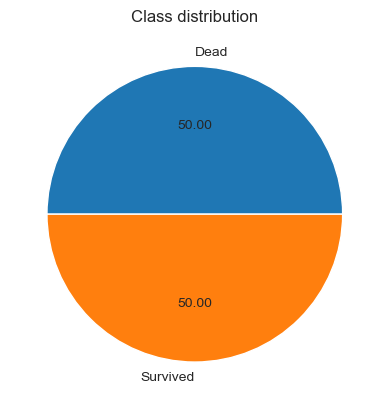

In [65]:
# Oversample on all the data
smote_oversampler_final = SMOTE(random_state=1)
X_train_all_res, y_train_all_res = smote_oversampler.fit_resample(X_train_all, y_train_all)
plot_classes(y_train_all_res)

In [66]:
def prepare_submission(model): 
    # Generate the predictions CSV
    predictions = model.predict(input_serving_df)
    submission = pd.DataFrame(data={'PassengerId': serving_df['PassengerId'],
                                    'Survived': predictions})

    submission.to_csv('submission.csv', index=False)

In [67]:
stacked_clf.fit(X_train_all_res, y_train_all_res)

StackingClassifier(cv=5,
                   estimators=[('rf',
                                RandomForestClassifier(max_depth=12,
                                                       n_estimators=200)),
                               ('adaboost',
                                AdaBoostClassifier(learning_rate=0.5,
                                                   n_estimators=250)),
                               ('xgboost',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=Fal...
                                              interaction_constraints=None,
                                              learning_rate=0.25, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=10,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=500, n_jobs=None,
                                              num_parallel_tree=None,
                                              predictor=None, random_state=None, ...))],
                   final_estimator=LogisticRegression(), n_jobs=-1)

In [68]:
prepare_submission(stacked_clf)

An accuracy of 74.401% was achieved. Though this result is not exceptional, many concepts were explored in this solution. This concludes this introductory project to Kaggle competitions. Another project will be tackled.